# EJEMPLO DE SEGUIMIENTO DE OBJETOS CON YOLO

## INSTALACIONES PREVIAS

In [1]:
!pip install ultralytics
!pip install -q gdown
!pip install -U supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.5/719.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 1.2 MB/s eta 0:00:00


In [2]:
import supervision as sv
import numpy as np
from ultralytics import YOLO
%matplotlib inline

## DESCARGAR EL VIDEO

In [5]:
!pip install ultralytics
import os
import ultralytics

HOME = os.getcwd()

%cd {HOME}
SOURCE_VIDEO_PATH = f"{HOME}/trafico.mp4"


/content


## CARGAR EL MODELO PREENTRENADO YOLOv8

In [6]:
MODEL = "yolov8x.pt" #Esta línea asigna el nombre del archivo de pesos preentrenado del modelo a la variable MODEL. El archivo ".pt" es típicamente un archivo de PyTorch que contiene los pesos entrenados del modelo.
model = YOLO(MODEL) #Aquí se crea una instancia del modelo YOLO utilizando el archivo de pesos especificado
model.fuse() #La fusión de capas es una técnica de optimización que combina ciertas capas y operaciones del modelo para reducir la complejidad computacional y mejorar el rendimiento en tiempo de ejecución. Por ejemplo, puede fusionar una capa de convolución seguida de una capa de BatchNorm en una sola capa de convolución

100%|██████████| 131M/131M [00:00<00:00, 164MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


## PREDECIR Y ANOTAR UN FOTOGRAMA

In [13]:
# Diccionario que mapea class_id a class_name
CLASS_NAMES_DICT = model.model.names
# class_ids de interés - coche, motocicleta, autobús y camión
selected_classes = [2]

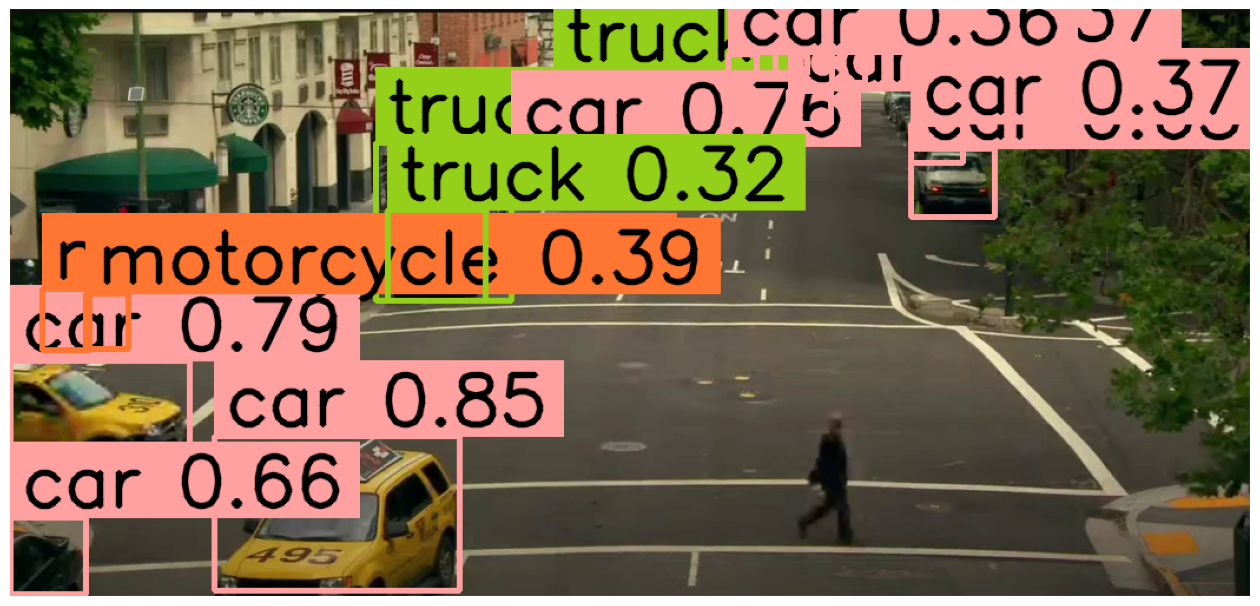

In [8]:
# Crear generador de fotogramas
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# Crear instancia de BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
# Adquirir el primer fotograma del vídeo
iterator = iter(generator)
frame = next(iterator)
# Predicción del modelo en un único fotograma y conversión a detecciones de supervisión
results = model(frame, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)
# Tener en cuenta solo las clases que queeremos
detections = detections[np.isin(detections.class_id, selected_classes)]
# formato de las etiquetas
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]
# Anotar y mostrar el fotograma
anotated_frame=box_annotator.annotate(scene=frame, detections=detections, labels=labels)  # Anotar el fotograma con cajas delimitadoras y etiquetas

sv.plot_image(anotated_frame, (16, 16))  # Mostrar el fotograma anotado en el cuaderno

## PREDECIR Y ANOTAR TODO EL VIDEO

In [22]:
# Definir el punto de inicio de la línea de conteo
LINE_START = sv.Point(50, 250)
# Definir el punto final de la línea de conteo
LINE_END = sv.Point(1000-50, 250)
# Establecer la ruta del video objetivo donde se guardará el resultado del conteo de vehículos
TARGET_VIDEO_PATH = f"{HOME}/trafico-result.mp4"

In [11]:
# Obtener información del video a partir de la ruta del video fuente
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1052, height=498, fps=60, total_frames=309)

In [28]:
# Crear una instancia de BYTETracker
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=60)
# Crear una instancia de VideoInfo
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# Crear un generador de fotogramas
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# Crear una instancia de LineCounter (la linea de conteo)
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)
# Crear instancias de BoxAnnotator, TraceAnnotator y  LineZoneAnnotator
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)
trace_annotator = sv.TraceAnnotator(thickness=1, trace_length=50)
line_zone_annotator = sv.LineZoneAnnotator(thickness=1, text_thickness=1, text_scale=0.5)

# función a ejecutar después en cada fotograma
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Predicción del modelo para el fotograma y conversión a detecciones de supervisión
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # Tener en cuenta solo las clases que queeremos
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # seguimiento de las detecciones
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id}"
        for confidence, class_id, tracker_id in zip(
            detections.confidence, detections.class_id, detections.tracker_id
        )
    ]
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(), detections=detections
    )
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels
    )

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)


# Procesar todo el video
sv.process_video(
    source_path=SOURCE_VIDEO_PATH, target_path=TARGET_VIDEO_PATH, callback=callback
)